### Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

### Read dataset

In [2]:
data_adsmart = pd.read_csv("AdSmartABdata.csv")

Dataset shape

In [3]:
data_adsmart.shape

(8077, 9)

Dataset samples

In [4]:
data_adsmart.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


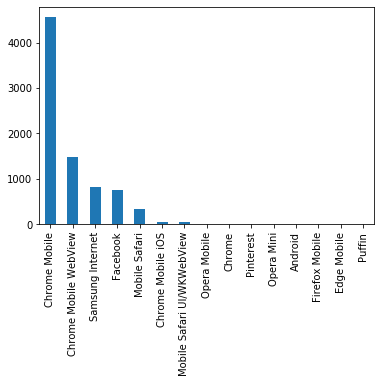

In [5]:
data_adsmart['browser'].value_counts().plot.bar()

## TODO descriptions

In [6]:
data_adsmart_clean = data_adsmart.drop(['auction_id', 'date', 'hour', 'device_make', 'platform_os', 'browser'], axis=1)
data_adsmart_clean = data_adsmart_clean[(data_adsmart_clean['yes'] != 0) | data_adsmart_clean['no'] != 0]
data_adsmart_clean['aware'] = 0
data_adsmart_clean.loc[data_adsmart_clean['yes'] == 1, 'aware'] = 1
data_adsmart_clean.loc[data_adsmart_clean['yes'] == 0, 'aware'] = 0

data_adsmart_clean

,experiment,yes,no,aware
2,exposed,0,1,0
16,exposed,1,0,1
20,exposed,0,1,0
23,control,1,0,1
27,control,0,1,0
...,...,...,...,...
8059,exposed,1,0,1
8063,exposed,1,0,1
8064,control,0,1,0
8069,control,0,1,0


In [220]:
ad_summary = data_adsmart_clean.pivot_table(values='aware', index='experiment', aggfunc=np.sum)

ad_summary['total'] = data_adsmart_clean.pivot_table(values='aware', index='experiment', aggfunc=lambda x: len(x))
ad_summary['not aware'] = ad_summary['total'] - ad_summary['aware']
ad_summary['rate'] = data_adsmart_clean.pivot_table(values='aware', index='experiment')
ad_summary = ad_summary.reindex(['aware', 'not aware', 'total', 'rate'], axis=1)
ad_summary

,aware,not aware,total,rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


There is a 1.8% difference in conversion rates between the two groups. It is a good sign but this is not enough evidence for us to confidently go with the new design.

# Comparing the two groups

In [117]:
# data_binom = binom.rvs(n=10,p=0.8,size=10000)
e_aware = ad_summary['aware']['exposed']
e_total = ad_summary['total']['exposed']
e_rate = ad_summary['rate']['exposed']

c_aware = ad_summary['aware']['control']
c_total = ad_summary['total']['control']
c_rate = ad_summary['rate']['control']

dif_cr = e_rate - c_rate

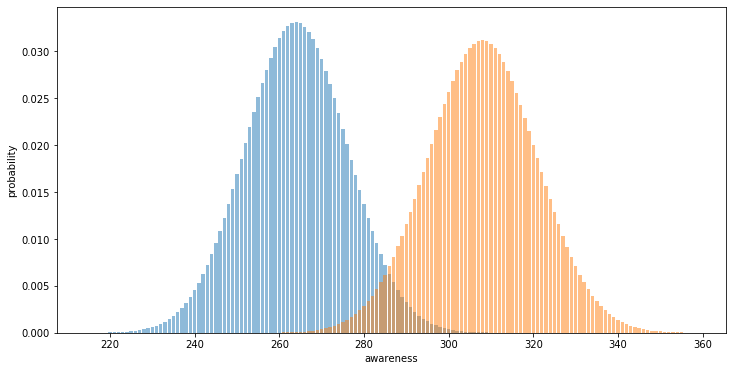

In [120]:
fig, ax = plt.subplots(figsize=(12,6))

xC = np.linspace(c_aware - 49, c_aware + 50, 100)
yC = scs.binom(c_total, c_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5)

xE = np.linspace(e_aware - 49, e_aware + 50, 100)
yE = scs.binom(e_total, e_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5)

plt.xlabel('awareness')
plt.ylabel('probability')
plt.show()

### Copied code

In [282]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)


def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist

def p_val(c_total, e_total, bcr, d_hat) :
    """Returns the p-value for an A/B test"""
    std_a = np.sqrt(bcr * (1 - bcr) / c_total)
    std_b = np.sqrt((bcr+d_hat) * (1 - (bcr+d_hat)) / e_total)
    z_score = (d_hat) / np.sqrt(std_a**2 + std_b**2)
    return  scs.norm().sf(z_score)

def plot_norm_dist(ax, mu, std, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        std (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_binom_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)

def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B) 

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')
        
    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(c_total, e_total, bcr, d_hat)  
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('distribution')
    plt.ylabel('PDF')
    plt.savefig('w4.png')
    plt.show()
    

def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')
    
    y_max = max(scs.norm(0, stderr).pdf(x))
    
    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.5',
                        where=(x > right))
        ax.text(-3 * stderr, y_max*0.9,
                'Power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='green')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='red', alpha='0.5',
                        where=(x > right))
        ax.text(-3 * stderr, y_max*0.8,
                'Alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='red')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='gray', alpha='0.5',
                        where=(x < right))
        ax.text(-3 * stderr, y_max*0.7,
                'Beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='gray')

def ab_confidence_plot(c_total, e_total, bcr, d_hat):
    std_a = np.sqrt(bcr * (1 - bcr) / c_total)
    std_b = np.sqrt((bcr+d_hat) * (1 - (bcr+d_hat)) / e_total)
    p = scs.norm(d_hat, np.sqrt(std_a**2 + std_b**2))
    x = np.linspace(-0.1, 0.15, 1000)
    y = p.pdf(x)
    area_under_curve = p.sf(0)
    
    plt.subplots(figsize=(12, 6))
    plt.plot(x, y, label="PDF")
    plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
    plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
    plt.legend()
    plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");
    plt.show()
    
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

### Expressing the two binomila distribution as a normal distribution

Text(0, 0.5, 'PDF')

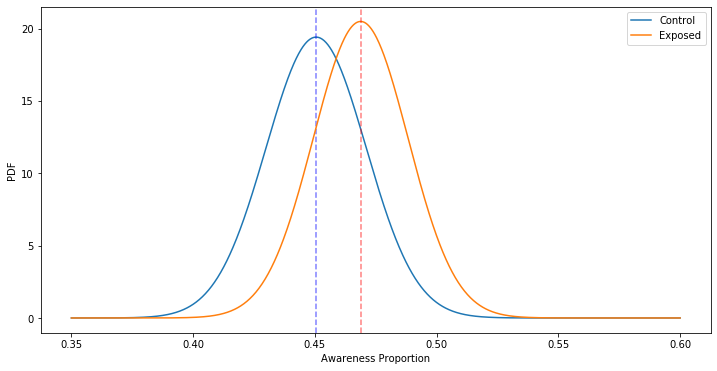

In [232]:
# standard error of the mean for both groups
SE_C = np.sqrt(c_rate * (1-c_rate)) / np.sqrt(c_total)
SE_E = np.sqrt(e_rate * (1-e_rate)) / np.sqrt(e_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))

x = np.linspace(.35, .6, 1000)

yC = scs.norm(c_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=c_rate, c='blue', alpha=0.5, linestyle='--')

yE = scs.norm(e_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=e_rate, c='red', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')

The graph in blue is control group distribution and in orange is exposed group distribution. The dashed vertical line which pass through the peaks are the mean conversion rate for each group.

### Plotting and the Null Hypothesis and the Alternative Hypothesis 

In [233]:
n = c_total, e_total
bcr = c_rate  
d_hat = e_rate - c_rate

### Power of the test, Beta value, Significant level (alpha) and P-value

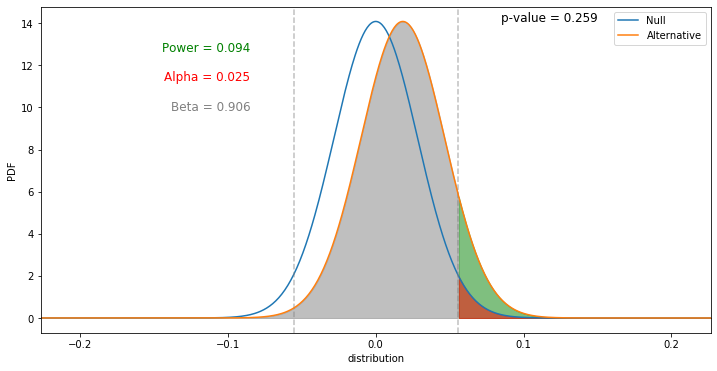

In [283]:
abplot(c_total, e_total, bcr, d_hat, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

Null hypothesis is in red and alternative hypothesis is in blue. There is a 1.8 difference between them. The gray dashed lines are confidence interval at 95% (0.05). 

There is a small value of power size of 0.094. What this is mean is there is a 9.4% probability of not making a type-II error. This is not a good sign that we will accept the outcome of this test.  

Beta value is the probability of making a type-II error. 90.6% is high probability making a type-II error

We take a significance level of 95%, whcih cross the x-axis at 0.025 on the right tail. We get a p-value of 0.259 that is greater than 0.05(significance level). Based on the p-value we failed to reject the Null hypotesis. But if we analyze the distribution graph and the power value we understand that the sample size taken to condact this testing is very small. There is a very high probability that we will make a type-II error. We need to gather more data to make a sounding conclusion from this testing.

### Confidence level

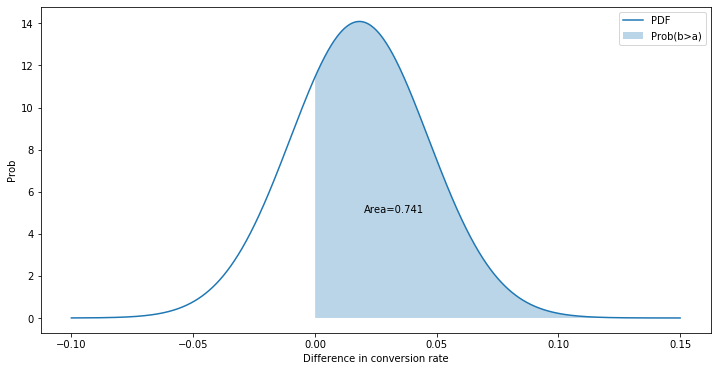

In [227]:
ab_confidence_plot(c_total, e_total, bcr, d_hat)

We get a value of 0.741 confidence interval. What this telling is is 74.1% of time the exposed group has same awareness with the control group and 25.1% of a time the exposed group has different awareness with the control group

### Conducting optimal sample size

Most people consider power of 80% or 90% (just as we generally use 95% as the confidence level for confidence interval estimates).

In [211]:
min_80 = min_sample_size(power=0.8, bcr=bcr, mde=d_hat)
min_90 = min_sample_size(power=0.9, bcr=bcr, mde=d_hat)
print(min_80)
min_90

11660.61386940473


15610.253593992478

By banlancing the power and the time and cost sample gathering takes we will make a decision. Here to have at least 80% power we need to have 11661 sample size.